## Comparing distributions - wrpped functions

In [39]:
import pandas as pd
import numpy as np
from itertools import product
from scipy.special import rel_entr
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from seaborn import displot
numeric_variable_nums = dict([('boston', 12), ('house',8),('sim_1', 0),('sim_2',0), ('sim_1_tiny',0), ('sim_2_tiny',0), ('sim_m1',1), ('sim_m2',1), ('sim_m3',1), ('sim_m4',1)])

In [2]:
# generate complete data's conditional distributions
def generate_cond(dataset, mr, size, sample_id):
    complete_data_path = '../training_data/samples/' + dataset + '/complete_' + str(mr) + '_' + str(size) + '/sample_' + str(sample_id) + '.csv'
    data = pd.read_csv(complete_data_path, header=None)

    # divide cat/num type
    num_index = list(range(data.shape[1] - numeric_variable_nums[dataset], data.shape[1]))
    cat_index = list(range(0, data.shape[1] - numeric_variable_nums[dataset]))

    # get all possible levels' combination for categorical variable
    all_levels = [np.unique(data.iloc[:,i]).tolist() for i in cat_index]
    all_levels_comb = list(product(*all_levels[:-1]))

    # calculate conditional distributions for complete data
    cond_dist_complete = dict.fromkeys(all_levels_comb, None)
    for index, item in data.iterrows():
        cond = (int(item[0]), int(item[1]), int(item[2]))
        if cond_dist_complete[cond] == None:
            cond_dist_complete[cond] = [0 for x in range(len(all_levels[-1]))]
        cond_dist_complete[cond][int(item[3])] += 1

    for key in cond_dist_complete.keys():
        denom = sum(cond_dist_complete[key])
        cond_dist_complete[key] = [round(x / denom, 3) for x in cond_dist_complete[key]]
    
    pdata = data.copy()
    pdata[3] = np.random.permutation(pdata[3])

    return all_levels, all_levels_comb, cond_dist_complete, pdata

In [3]:
# calculate kl result for permutation data
def perm_kl_result(all_levels, all_levels_comb, cond_dist_complete, perm_data):
    cond_dist_imputed = dict.fromkeys(all_levels_comb, None)
    for index, item in perm_data.iterrows():
            cond = (item[0], item[1], item[2])
            if cond_dist_imputed[cond] == None:
                cond_dist_imputed[cond] = [0 for x in range(len(all_levels[-1]))]
            cond_dist_imputed[cond][int(item[3])] += 1

    for key in cond_dist_imputed.keys():
        denom = sum(cond_dist_imputed[key])
        cond_dist_imputed[key] = [round(x / denom, 3) for x in cond_dist_imputed[key]]

    # output comparing KL divergence
    comparison_dict = dict.fromkeys(all_levels_comb, None)
    for key in comparison_dict.keys():
        if cond_dist_imputed[key] == None:
            continue
        comparison_dict[key] = round(sum(rel_entr(cond_dist_complete[key], cond_dist_imputed[key])),6)
    average_kl = np.average(list(comparison_dict.values()))
    return average_kl, comparison_dict

In [4]:
# output KL divergence for each pair of conditional distribution in one sample
def kl_comparison(method, imputed_data_folder, all_levels, all_levels_comb, cond_dist_complete, sample_id, impute_num):
    # calculate conditional distributions from imputed datasets
    cond_dist_imputed = dict.fromkeys(all_levels_comb, None)
    for i in range(impute_num):
        current_imputed_dir = imputed_data_folder + 'imputed_' + str(sample_id) + '_' + str(i) + '.csv'
        imputed_data = pd.read_csv(current_imputed_dir, header=None)
        for index, item in imputed_data.iterrows():
            if (method == 'cart'):
                item = [int(item[0] - 1), int(item[1] - 1), int(item[2] - 1), int(item[3] - 1)]
            cond = (int(item[0]), int(item[1]), int(item[2]))
            
            if cond_dist_imputed[cond] == None:
                cond_dist_imputed[cond] = [0 for x in range(len(all_levels[-1]))]
            cond_dist_imputed[cond][int(item[3])] += 1

    for key in cond_dist_imputed.keys():
        if cond_dist_imputed[key] == None:
            continue
        denom = sum(cond_dist_imputed[key])
        cond_dist_imputed[key] = [round(x / denom, 3) for x in cond_dist_imputed[key]]

    # output comparing KL divergence
    comparison_dict = dict.fromkeys(all_levels_comb, None)
    for key in comparison_dict.keys():
        if cond_dist_imputed[key] == None:
            continue
        comparison_dict[key] = round(sum(rel_entr(cond_dist_complete[key], cond_dist_imputed[key])),6)
    average_kl = np.average(list(comparison_dict.values()))
    return average_kl, comparison_dict, cond_dist_imputed


In [28]:
# output conditional distribution plots
def cd_plots(cond_dist_complete, cond_dist_imputed, method_list, nrow, ncol, cond = None):
    
    if cond == None:
        x_lab = range(4)
        figure, axes = plt.subplots(nrows=nrow, ncols = ncol, figsize = (15,15))
        axes = axes.reshape(1,-1)
        indx = 0

        for key in cond_dist_complete.keys():
            cond_dist = cond_dist_complete[key]
            compare_data = pd.DataFrame({'Ground Truth': cond_dist})
            for method in method_list:
                imputed_dist = cond_dist_imputed[method][key]
                compare_data[method] = imputed_dist
            compare_data.plot(kind = 'bar', ylim = [0,1], title=str(key), ax = axes[0][indx], legend=False)
            indx += 1
        bar,label = axes[0][0].get_legend_handles_labels()
        figure.legend(bar, label, loc = 'upper right')
        plt.subplots_adjust(hspace=1)
        plt.show()
    
    else:
        x_lab = range(4)
        cond_dist = cond_dist_complete[cond]
        compare_data = pd.DataFrame({'Ground Truth': cond_dist})
        for method in method_list:
            imputed_dist = cond_dist_imputed[method][cond]
            compare_data[method] = imputed_dist
        compare_data = pd.DataFrame({'Ground Truth': cond_dist, 'Imputation': imputed_dist}, 
                                    index=x_lab)
        compare_data.plot(kind = 'bar', ylim = [0,1], title=str(cond))


### sim_1

In [27]:
# complete data
# readin datasets (complete dataset)
dataset = 'sim_1'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
all_levels, all_levels_comb, cond_dist_complete, perm_data = generate_cond(dataset, mr, size, sample_id)

In [18]:
# rand result
perm_kl_result(all_levels, all_levels_comb, cond_dist_complete, perm_data)

[1.220069, 0.426697, 0.181805, 0.659439, 0.260634, 0.67118, 0.901205, 0.382857, 0.506973, 0.48859, 0.456542, 0.785712, 0.559643, 0.428726, 0.690983, 0.27329, 0.487196, 1.195497]


(0.5876132222222223,
 {(0.0, 0.0, 0.0): 1.220069,
  (0.0, 0.0, 1.0): 0.426697,
  (0.0, 0.0, 2.0): 0.181805,
  (0.0, 1.0, 0.0): 0.659439,
  (0.0, 1.0, 1.0): 0.260634,
  (0.0, 1.0, 2.0): 0.67118,
  (1.0, 0.0, 0.0): 0.901205,
  (1.0, 0.0, 1.0): 0.382857,
  (1.0, 0.0, 2.0): 0.506973,
  (1.0, 1.0, 0.0): 0.48859,
  (1.0, 1.0, 1.0): 0.456542,
  (1.0, 1.0, 2.0): 0.785712,
  (2.0, 0.0, 0.0): 0.559643,
  (2.0, 0.0, 1.0): 0.428726,
  (2.0, 0.0, 2.0): 0.690983,
  (2.0, 1.0, 0.0): 0.27329,
  (2.0, 1.0, 1.0): 0.487196,
  (2.0, 1.0, 2.0): 1.195497})

In [38]:
# comparison between three methods
method_list = ['gain','cart','vaeac']
average_kl = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)

for method in method_list:
    imputed_data_folder = './results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = kl_comparison(method,imputed_data_folder,
                         all_levels, all_levels_comb, cond_dist_complete,
                         sample_id, impute_num)
    average_kl[method], comparison_dict[method], cond_dist_imputed[method] = result

average_kl
    

{'gain': 0.05098988888888889,
 'cart': 0.007968722222222223,
 'vaeac': 0.19053716666666667}

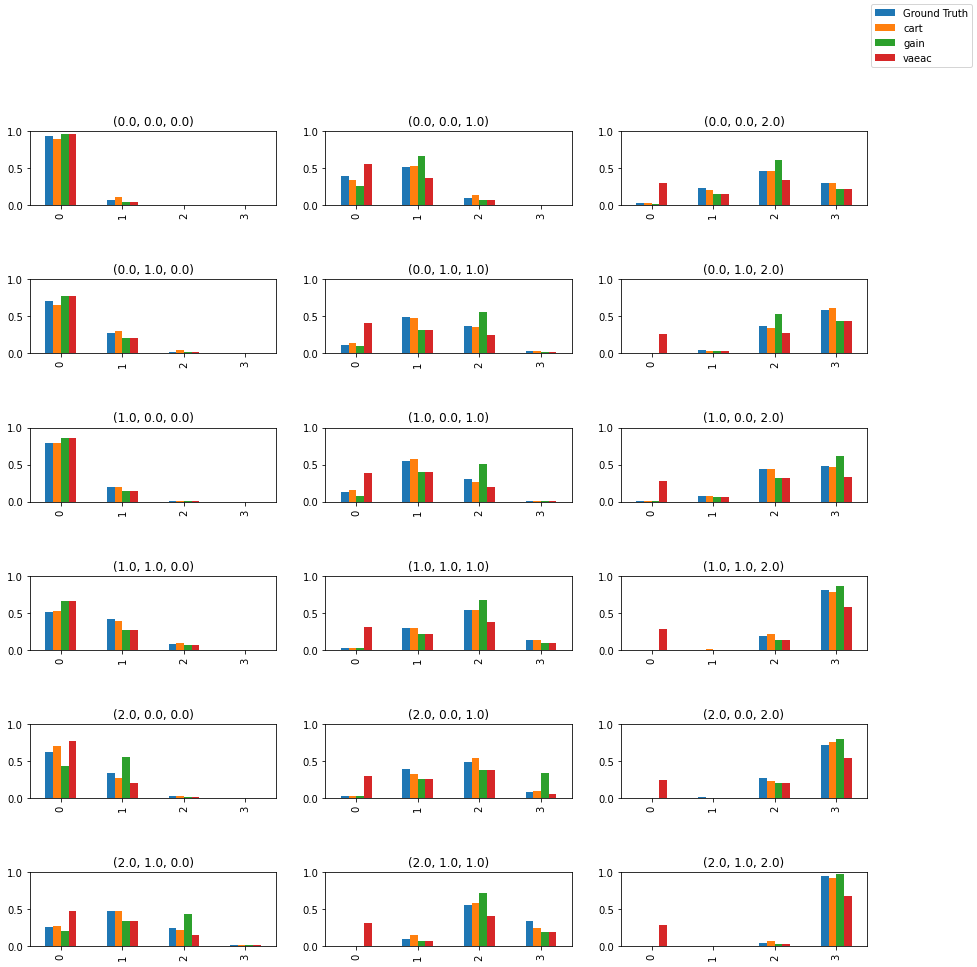

In [39]:
# conditional distributions 
method_list = ['cart','gain','vaeac']
cd_plots(cond_dist_complete, cond_dist_imputed,method_list, 6,3)

In [6]:
# renew VAE's metric
dataset = 'sim_1'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
all_levels, all_levels_comb, cond_dist_complete, perm_data = generate_cond(dataset, mr, size, sample_id)

In [7]:
average_kl, comparison_dict = perm_kl_result(all_levels, all_levels_comb, cond_dist_complete, perm_data)
average_kl

0.5966370555555556

In [8]:
method_list = ['vaeac']
average_kl = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)

for method in method_list:
    imputed_data_folder = '../training_data/results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = kl_comparison(method,imputed_data_folder,
                         all_levels, all_levels_comb, cond_dist_complete,
                         sample_id, impute_num)
    average_kl[method], comparison_dict[method], cond_dist_imputed[method] = result

print(average_kl)
print(cond_dist_imputed[method].values())

{'vaeac': 0.19053716666666667}
dict_values([[0.955, 0.045, 0.0, 0.0], [0.554, 0.371, 0.075, 0.0], [0.297, 0.152, 0.334, 0.217], [0.776, 0.202, 0.023, 0.0], [0.415, 0.322, 0.243, 0.02], [0.257, 0.03, 0.279, 0.434], [0.853, 0.138, 0.01, 0.0], [0.385, 0.401, 0.204, 0.01], [0.281, 0.062, 0.321, 0.336], [0.661, 0.274, 0.065, 0.0], [0.314, 0.212, 0.376, 0.098], [0.285, 0.0, 0.133, 0.582], [0.771, 0.207, 0.022, 0.0], [0.303, 0.265, 0.379, 0.053], [0.25, 0.003, 0.2, 0.547], [0.48, 0.349, 0.156, 0.015], [0.31, 0.077, 0.414, 0.199], [0.29, 0.0, 0.029, 0.68]])


In [10]:
method_list = ['vaeac']
average_kl = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)

for method in method_list:
    imputed_data_folder = '../training_data/results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = kl_comparison(method,imputed_data_folder,
                         all_levels, all_levels_comb, cond_dist_complete,
                         sample_id, impute_num)
    average_kl[method], comparison_dict[method], cond_dist_imputed[method] = result

print(average_kl)
print(cond_dist_imputed[method].values())

{'vaeac': 0.19053716666666667}
dict_values([[0.955, 0.045, 0.0, 0.0], [0.554, 0.371, 0.075, 0.0], [0.297, 0.152, 0.334, 0.217], [0.776, 0.202, 0.023, 0.0], [0.415, 0.322, 0.243, 0.02], [0.257, 0.03, 0.279, 0.434], [0.853, 0.138, 0.01, 0.0], [0.385, 0.401, 0.204, 0.01], [0.281, 0.062, 0.321, 0.336], [0.661, 0.274, 0.065, 0.0], [0.314, 0.212, 0.376, 0.098], [0.285, 0.0, 0.133, 0.582], [0.771, 0.207, 0.022, 0.0], [0.303, 0.265, 0.379, 0.053], [0.25, 0.003, 0.2, 0.547], [0.48, 0.349, 0.156, 0.015], [0.31, 0.077, 0.414, 0.199], [0.29, 0.0, 0.029, 0.68]])


### sim_2

In [22]:
# complete data
# readin datasets (complete dataset)
dataset = 'sim_2'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
all_levels, all_levels_comb, cond_dist_complete, perm_data = generate_cond(dataset, mr, size, sample_id)

In [23]:
# rand result
perm_kl_result(all_levels, all_levels_comb, cond_dist_complete, perm_data)

[0.046429, 0.047712, 0.091113, 1.204747, 0.674148, 0.010496, 0.022096, 0.059605, 0.196473, 0.377025, 0.052042, 0.394743, 0.097519, 0.267855, 0.371849, 0.064264, 0.259836, 0.895627]


(0.28519883333333335,
 {(0.0, 0.0, 0.0): 0.046429,
  (0.0, 0.0, 1.0): 0.047712,
  (0.0, 0.0, 2.0): 0.091113,
  (0.0, 1.0, 0.0): 1.204747,
  (0.0, 1.0, 1.0): 0.674148,
  (0.0, 1.0, 2.0): 0.010496,
  (1.0, 0.0, 0.0): 0.022096,
  (1.0, 0.0, 1.0): 0.059605,
  (1.0, 0.0, 2.0): 0.196473,
  (1.0, 1.0, 0.0): 0.377025,
  (1.0, 1.0, 1.0): 0.052042,
  (1.0, 1.0, 2.0): 0.394743,
  (2.0, 0.0, 0.0): 0.097519,
  (2.0, 0.0, 1.0): 0.267855,
  (2.0, 0.0, 2.0): 0.371849,
  (2.0, 1.0, 0.0): 0.064264,
  (2.0, 1.0, 1.0): 0.259836,
  (2.0, 1.0, 2.0): 0.895627})

In [24]:
method_list = ['gain','cart', 'vaeac']
average_kl = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)

for method in method_list:
    imputed_data_folder = './results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = kl_comparison(method,imputed_data_folder,
                         all_levels, all_levels_comb, cond_dist_complete,
                         sample_id, impute_num)
    average_kl[method], comparison_dict[method], cond_dist_imputed[method] = result

In [25]:
average_kl

{'gain': 0.07470694444444444,
 'cart': 0.0077919999999999994,
 'vaeac': 0.1528415}

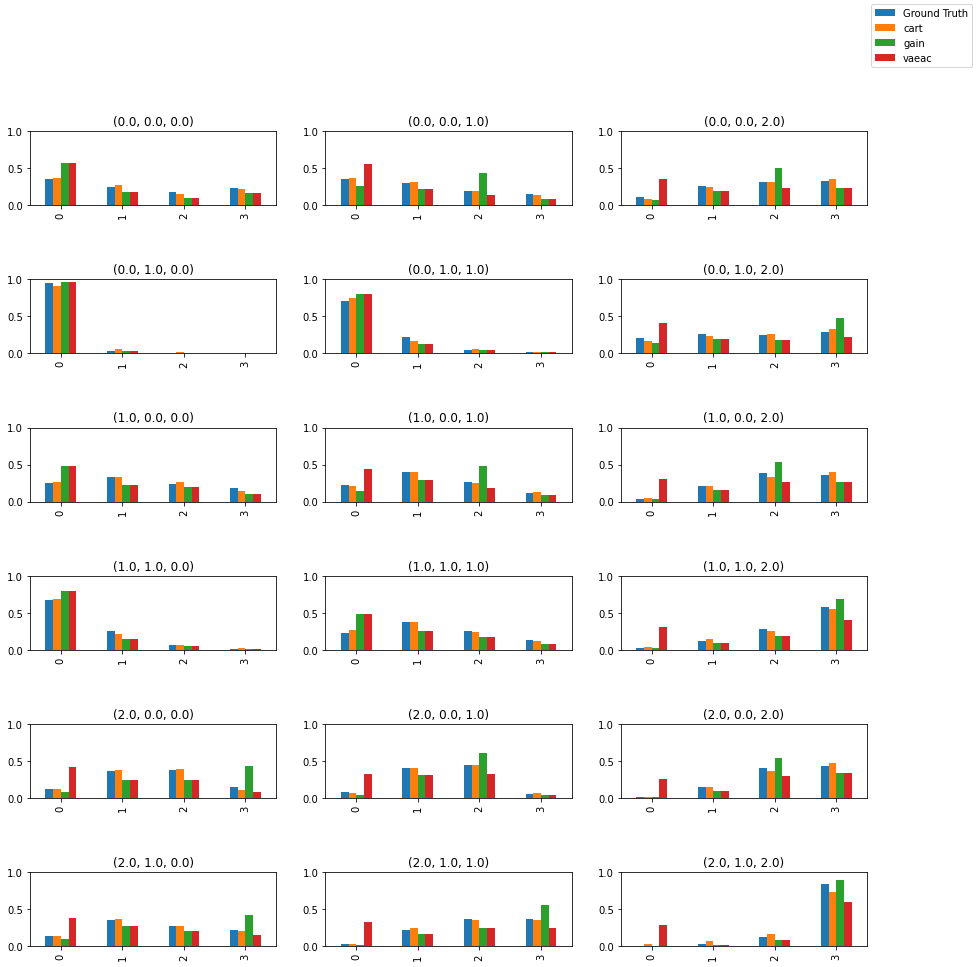

In [26]:
method_list = ['cart','gain', 'vaeac']
cd_plots(cond_dist_complete, cond_dist_imputed,method_list, 6,3)

## x is categorical, y is continuous - wrapped functions

In [4]:
# generate complete data's conditional distributions (x is categorical, y is continuous)
# tag each data piece with corresponding condition
# each value in cond_dist_complete is a dataset

def strint(x):
    return str(int(x))

def generate_cond_cont(dataset, mr, size, sample_id, attn_var):
    complete_data_path = '../training_data/samples/' + dataset + '/complete_' + str(mr) + '_' + str(size) + '/sample_' + str(sample_id) + '.csv'
    data = pd.read_csv(complete_data_path, header=None)

    # get all possible levels' combination for categorical variable that we specified
    all_levels = [np.unique(data.iloc[:,i]).tolist() for i in attn_var]
    all_levels_comb = list(product(*all_levels))

    # extract conditional distributions for complete data
    cond_dist_complete = dict.fromkeys(all_levels_comb, None)
    condtag = []
    
    for index, item in data.iterrows():
        cond = '-'.join([strint(item[i]) for i in attn_var])
        condtag.append(cond)
    
    data['cond'] = condtag
    
    for key in all_levels_comb:
        str_key = '-'.join([strint(key[i]) for i in attn_var])
        cond_dist_complete[key] = data.loc[data['cond'] == str_key][5].values.tolist()
    
    pdata = data.copy()
    pdata[5] = np.random.permutation(pdata[5])

    return all_levels, all_levels_comb, cond_dist_complete, pdata

In [5]:
# output MSE/MAE for each pair of specified conditional distribution in one sample
# extract conditional dataset from imputed datasets
def metric_comparison(method, imputed_data_folder, all_levels, all_levels_comb, cond_dist_complete, attn_var, sample_id, impute_num):

    cond_dist_imputed = dict.fromkeys(all_levels_comb, [])
    mse_list = dict.fromkeys(all_levels_comb, [])
    mae_list = dict.fromkeys(all_levels_comb, [])

    for i in range(impute_num):
        current_imputed_dir = imputed_data_folder + 'imputed_' + str(sample_id) + '_' + str(i) + '.csv'
        imputed_data = pd.read_csv(current_imputed_dir, header=None)
        condtag = []
        
        for index, item in imputed_data.iterrows():
            if (method == 'cart'):
                item = [int(item[x] - 1) for x in range(len(item))]
            cond = '-'.join([strint(item[i]) for i in attn_var])
            condtag.append(cond)
        
        imputed_data['cond'] = condtag

        for key in all_levels_comb:
            str_key = '-'.join([strint(key[i]) for i in range(len(key))])
            cond_imputed_data = imputed_data.loc[imputed_data['cond'] == str_key][5].values.tolist()
            
            # add data to imputed conditional distribution
            cond_dist_imputed[key].append(cond_imputed_data)

            # calculate metrics
            y_true = cond_dist_complete[key]
            mse_list[key].append(mean_squared_error(y_true, cond_imputed_data))
            mae_list[key].append(mean_absolute_error(y_true, cond_imputed_data))
        
        return cond_dist_imputed, mse_list, mae_list

In [63]:
# calculate MSE result for permutation data (x is categorical, y is continuous)
def perm_metric_result(all_levels, all_levels_comb, cond_dist_complete, perm_data, attn_var):
    
    cond_dist_imputed = dict.fromkeys(all_levels_comb, None)
    mse_list = dict.fromkeys(all_levels_comb, None)
    mae_list = dict.fromkeys(all_levels_comb, None)
    condtag = []
        
    for index, item in perm_data.iterrows():
        cond = '-'.join([strint(item[i]) for i in attn_var])
        condtag.append(cond)
    
    perm_data['cond'] = condtag

    for key in all_levels_comb:
        str_key = '-'.join([strint(key[i]) for i in range(len(key))])
        cond_imputed_data = perm_data.loc[perm_data['cond'] == str_key][5].values.tolist()
        
        # add data to imputed conditional distribution
        cond_dist_imputed[key] = cond_imputed_data

        # calculate metrics
        y_true = cond_dist_complete[key]
        mse_list[key] = mean_squared_error(y_true, cond_imputed_data)
        mae_list[key] = mean_absolute_error(y_true, cond_imputed_data)
    
    return cond_dist_imputed, mse_list, mae_list

In [56]:
# draw comparing density plots
def cd_density_plots(all_levels_comb, cond_dist_complete, cond_dist_imputed, nrow, ncol):
    
    #_, axes = plt.subplots(nrows=nrow, ncols = ncol, figsize = (15,15))
    #axes = axes.reshape(1,-1)
    indx = 0
    
    for key in all_levels_comb:
        dataset = pd.DataFrame({'GT':cond_dist_complete[key], 'imputed':cond_dist_imputed[key]})
        dataset = pd.melt(dataset, var_name='Dataset',value_name='value')
        displot(dataset, kind='kde', hue='Dataset', x = 'value')
        indx += 1

###  sim_3

M1 - $Y = X_1^2 + \exp(X_2 + X_3/3) + \sin(X_4 + X_5) + \epsilon, \epsilon \sim N(0,1)$

In [61]:
# complete data
# readin datasets (complete dataset)
dataset = 'sim_m1'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
attn_var = [0,1]
all_levels, all_levels_comb, cond_dist_complete, perm_data = generate_cond_cont(dataset, mr, size, sample_id, attn_var)

In [60]:
cond_dist_perm, mse_perm, mae_perm = perm_metric_result(all_levels, all_levels_comb, cond_dist_complete, perm_data, attn_var)

col_key = all_levels_comb
mse_avr = [np.average(item) for item in mse_perm.values()]
mae_avr = [np.average(item) for item in mae_perm.values()]
result = pd.DataFrame({'key': col_key, 'mse' :mse_avr, 'mae' : mae_avr})
result.loc['avr'] = result.mean()

result

,key,mse,mae
0,"(0.0, 0.0)",14.611161,2.670516
1,"(0.0, 1.0)",25.362473,3.421818
2,"(1.0, 0.0)",18.997905,2.908228
3,"(1.0, 1.0)",24.658261,3.159304
4,"(2.0, 0.0)",12.282207,2.552266
5,"(2.0, 1.0)",27.654116,3.535271
avr,NaN,20.594354,3.041234


## sim_4

M2 - $Y = X_1^2 + \exp(X_2 + X_3/3) + X_4 - X_5 + (0.5 + X_2^2/2 + X_5^2/2) \times \epsilon, \epsilon \sim N(0,1)$

## sim_5

M3 - $Y = (5+X_1^2/3 + X_2^2 + X_3^2 + X_4 + X_5) \times \exp(0.5 \times \epsilon), \epsilon \sim \boldsymbol{I}_{U<0.5}\times N(-2,1)+\boldsymbol{I}_{U>0.5} \times N(2,1)$

## sim_6

M4 - $Y = \boldsymbol{I}_{u<0.5}\times N(-X_1, 0.25^2) + \boldsymbol{I}_{u>0.5}\times N(X_1, 0.25^2)$